# Clustering Lab

## Group: &lt; Lab Group Number here &gt;

### Members: &lt; Members of the group here &gt; 

Grouping data into other data that is similar to it is sometimes very helpful in defining categories on data, and adding structure to a visuzliation. 

We'll look at several examples of using libraries to cluster data using
  - k-means
  - dbscan, and
  - hierarchical clustering
  
  

## Our data

There are 234 exoplanets listed by [NASA](https://exoplanets.nasa.gov/discovery/exoplanet-catalog/) that orbit stars that are visible to the naked eye (as of DL time April 2021). Let's use this data to form clusters! 

In [498]:
import pandas as pd
import numpy as np
import altair as alt

# For k-means and dbscan
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# This is for our hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt

In [499]:
# This data is actually tab seperated, so I'll pass in a delimter argument. 
df = pd.read_csv('https://gist.githubusercontent.com/TieJean/1d7f7b21fd0220e365c89145eecb0571/raw/fcf54bf8966223f4b8227f07a287d832e6ef39b1/exoplanets.csv', delimiter='\t')

In [500]:
# We use `head` and `tail` quite a bit, let's look at another with to get some data with `sample` 
# sample will randomly pull the argument number of rows from the dataframe.
df.sample(35)

,NAME,LIGHT-YEARS FROM EARTH,PLANET MASS,STELLAR MAGNITUDE,DISCOVERY DATE
27,Alpha Arietis b,66.0,1.8 Jupiters,2.00538,2010
75,HD 20794 e,20.0,4.77 Earths,4.26000,2017
207,OGLE-2018-BLG-1011L c,23160.0,2.8 Jupiters,NaN,2019
189,OGLE-2016-BLG-0263L b,21203.0,4.1 Jupiters,NaN,2017
162,OGLE-2006-BLG-109L b,4926.0,0.727 Jupiters,NaN,2008
65,HD 169830 b,123.0,2.88 Jupiters,5.90000,2000
201,OGLE-2017-BLG-1375L b,12820.0,11.28 Jupiters,NaN,2020
136,MOA-2007-BLG-192L b,3262.0,3.3 Earths,NaN,2008
232,WISEP J121756.91+162640.2 A b,33.0,22 Jupiters,NaN,2012
57,HD 147513 b,42.0,1.21 Jupiters,5.37000,2003


## Data Engineering!

As some of you are discovering in your final projects, data engineering can be difficult process. 
In this data set, we don't have to worry about merging and joining, but our clustering algorithms
take in numerical data.  Let's check our columns and see what type of data we have:

In [501]:
df.dtypes

NAME                       object
LIGHT-YEARS FROM EARTH    float64
PLANET MASS                object
STELLAR MAGNITUDE         float64
DISCOVERY DATE              int64
dtype: object

... That 'object' for Planet Mass is a problem!! We can see that it has units encoded in it, "Jupiters" or "Earths"

Lets count how many Earths and how many Jupiters there are:

In [502]:
df['PLANET MASS'].str.match(r'(.*Earths$)').sum()

56

and now Jupiters

In [503]:
df['PLANET MASS'].str.match(r'(.*Jupiters$)').sum()

178

A quick check, and we find that these two units cover all the rows in the dataframe.  Now, how do we strip the
units off and normalize the column so that they are all in the same units?  

Let's first store the index that has the earth units 

In [504]:
earth_index = df['PLANET MASS'].str.match(r'(.*Earths$)')
earth_index

0      False
1      False
2      False
3      False
4      False
       ...  
229    False
230    False
231    False
232    False
233    False
Name: PLANET MASS, Length: 234, dtype: bool

We can now use this to filter out the earth units in the whole dataframe like so:

In [505]:
df[earth_index]

,NAME,LIGHT-YEARS FROM EARTH,PLANET MASS,STELLAR MAGNITUDE,DISCOVERY DATE
15,55 Cancri e,41.0,7.99 Earths,5.95084,2004
17,61 Virginis b,28.0,5.1 Earths,4.69550,2009
18,61 Virginis c,28.0,18.2 Earths,4.69550,2009
19,61 Virginis d,28.0,22.9 Earths,4.69550,2009
43,HD 102365 b,30.0,16 Earths,4.89000,2010
51,HD 136352 b,48.0,4.62 Earths,5.65000,2019
52,HD 136352 c,48.0,11.29 Earths,5.65000,2019
53,HD 136352 d,48.0,10.5 Earths,5.65000,2019
61,HD 160691 d,51.0,10.5547 Earths,5.12000,2004
63,HD 16417 b,83.0,22.1 Earths,5.78000,2008


Now, let's strip out the letters from the planet mass column, while printing out some before and afters
so we can check our work

In [506]:
df.tail()

,NAME,LIGHT-YEARS FROM EARTH,PLANET MASS,STELLAR MAGNITUDE,DISCOVERY DATE
229,Upsilon Andromedae b,44.0,0.6876 Jupiters,4.09565,1996
230,Upsilon Andromedae c,44.0,1.981 Jupiters,4.09565,1999
231,Upsilon Andromedae d,44.0,4.132 Jupiters,4.09565,1999
232,WISEP J121756.91+162640.2 A b,33.0,22 Jupiters,NaN,2012
233,Xi Aquilae b,183.0,2.8 Jupiters,4.70964,2007


In [507]:
df['PLANET MASS'].replace('[A-Z][a-z]+','',regex=True, inplace = True)
df.tail()

,NAME,LIGHT-YEARS FROM EARTH,PLANET MASS,STELLAR MAGNITUDE,DISCOVERY DATE
229,Upsilon Andromedae b,44.0,0.6876,4.09565,1996
230,Upsilon Andromedae c,44.0,1.981,4.09565,1999
231,Upsilon Andromedae d,44.0,4.132,4.09565,1999
232,WISEP J121756.91+162640.2 A b,33.0,22,NaN,2012
233,Xi Aquilae b,183.0,2.8,4.70964,2007


In [508]:
df[earth_index].head()

,NAME,LIGHT-YEARS FROM EARTH,PLANET MASS,STELLAR MAGNITUDE,DISCOVERY DATE
15,55 Cancri e,41.0,7.99,5.95084,2004
17,61 Virginis b,28.0,5.1,4.69550,2009
18,61 Virginis c,28.0,18.2,4.69550,2009
19,61 Virginis d,28.0,22.9,4.69550,2009
43,HD 102365 b,30.0,16,4.89000,2010


Now, we have to convert from the `object` type to the `float64` in the planet mass column

In [509]:
df['PLANET MASS'] = pd.to_numeric(df['PLANET MASS'])

In [510]:
# Check it!
df.dtypes

NAME                       object
LIGHT-YEARS FROM EARTH    float64
PLANET MASS               float64
STELLAR MAGNITUDE         float64
DISCOVERY DATE              int64
dtype: object

The earth units now need to be converted to Jupiters. Some googling tells me that

  - Earth is 5.972 × 10^24 kg
  - Jupiter is 1.898 × 10^27 kg

So how many earths in one jupiter?

In [511]:
(1.898 * 10**27)/(5.972 * 10**24)

317.8164768921634

To convert earths to jupiters, we divide all of the Earth units by the above number

In [512]:
df.loc[earth_index,'PLANET MASS'] = df.loc[earth_index,'PLANET MASS']/317.816

Now, let's look at LIGHT-YEARS FROM EARTH as a function of PLANET MASS

In [513]:
alt.Chart(df).mark_circle().encode(
    x='PLANET MASS:Q',
    y='LIGHT-YEARS FROM EARTH:Q'
)

alt.Chart(...)

This looks very bunched up in mass!  Why don't we try ploting the LIGHT-YEARS FROM EARTH as a function of the log of the PLANET MASS instead?

In [514]:
alt.Chart(df).mark_circle().encode(
    x=alt.X('PLANET MASS:Q',scale=alt.Scale(type="log")),
    y='LIGHT-YEARS FROM EARTH:Q'
)

alt.Chart(...)

hmmm ... how about a log log plot? (where both axes are on a log scale)

In [515]:
alt.Chart(df).mark_circle().encode(
    x=alt.X('PLANET MASS:Q',scale=alt.Scale(type="log")),
    y=alt.Y('LIGHT-YEARS FROM EARTH:Q',scale=alt.Scale(type="log"))
)

alt.Chart(...)

## The clustering algorthms

Now, lets look at the scikit-learn libraries and learn how to use them to cluster. 

### K-Means

First step is to generate some toy data, and we'll use a built in random blob generator:

In [516]:
X, y = make_blobs(n_samples=100,
                  n_features=2,
                  centers=3,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=23)

In [517]:
df_toy = pd.DataFrame()
df_toy['x'] = X[:,0]
df_toy['y'] = X[:,1]
df_toy['cluster'] = y

In [518]:
alt.Chart(df_toy).mark_circle().encode(
    x='x',
    y='y',
    color='cluster:N'
)

alt.Chart(...)

What happens if we try to cluster the data with $k=2$?

In [519]:
# Creates the object that will perform k-means with k=2
clusterer = KMeans(n_clusters=2, random_state=10)

# fit_predict will assign cluster labels to the data passed in as a parameter
df_toy['new_cluster_labels'] = clusterer.fit_predict(X)

alt.Chart(df_toy).mark_circle().encode(
    x='x',
    y='y',
    color='new_cluster_labels:N'
)

alt.Chart(...)

In [520]:
# inspect df_toy for fun
df_toy.sample(10)

,x,y,cluster,new_cluster_labels
79,-7.482608,3.480819,2,1
29,0.209691,10.206500,0,1
91,0.094813,10.532363,0,1
92,-7.347948,2.280610,2,1
90,0.668229,8.999595,0,1
10,5.535707,-4.118185,1,0
30,-5.463262,4.389537,2,1
84,1.074834,10.907687,0,1
24,0.858095,9.070791,0,1
87,-0.074886,8.387264,0,1


### DBScan

K-means works well on blob data, but sometimes we want to consider clusters that are continuously dense, and not necessarily blobs. 

There is another built-in random number generator that will make us `C`'s (or cresent moons)

In [521]:
X, y = make_moons(200, noise=.05, random_state=23)
df_toy = pd.DataFrame()
df_toy['x'] = X[:,0]
df_toy['y'] = X[:,1]
df_toy['cluster'] = y

alt.Chart(df_toy).mark_circle().encode(
    x='x',
    y='y',
    color='cluster:N'
)

alt.Chart(...)

In [522]:
# Creates the object and fit the data in the same call.  The params eps and min_samples are hyperparameters
db = DBSCAN(eps=0.5, min_samples=10).fit(X)

df_toy['new_cluster_labels'] = db.labels_

alt.Chart(df_toy).mark_circle().encode(
    x='x',
    y='y',
    color='new_cluster_labels:N'
)

alt.Chart(...)

What happened?  The values eps and min_samples are hyper parameters that define the density.  Lets' try with a different set of hyperparameters:

In [523]:
# Creates the object and fit the data in the same call.  The params eps and min_samples are hyperparameters
db = DBSCAN(eps=0.3, min_samples=10).fit(X)

df_toy['new_cluster_labels'] = db.labels_

alt.Chart(df_toy).mark_circle().encode(
    x='x',
    y='y',
    color='new_cluster_labels:N'
)

alt.Chart(...)

Much better!  Now, the cluster label matches what we expected from generating the data!

### Hierarchical Clustering 

To demonstrate hierarchical clustering, we'll use the voting records of the US states in presidential elections. 
This is data from _before_ our last election. 

In [524]:
# Load the data, save off the state names into another series and just leave the attributes.
df_X = pd.read_csv('https://gist.githubusercontent.com/TieJean/a4acaad907d1dcec6497e049fb2d3857/raw/d0144e9092547a627d5b746725cbdb73f1558159/republican_percentage_by_state.csv')
s_states = df_X['State']
df_X = df_X.drop(columns=['State'])

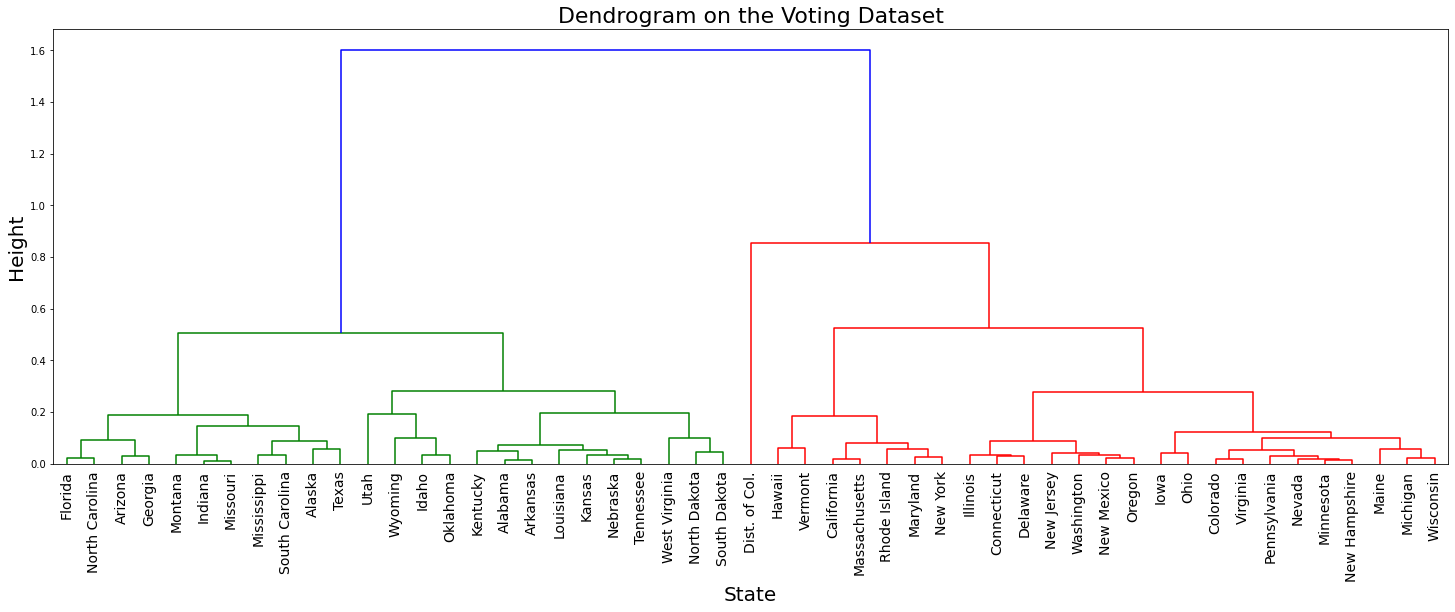

In [525]:
# Plot the dendrogram for the Ward proximity measure
Z = linkage(df_X, 'ward')
fig = plt.figure(figsize=(25, 8))
dn = dendrogram(Z, labels=list(s_states), leaf_font_size=14)
plt.title("Dendrogram on the Voting Dataset", fontsize=22)
plt.xlabel("State", size=20)
plt.ylabel("Height", size=20)
plt.show()

Note that Arizona and Georgia are in the same cluster! Isn't that interesting? So are Michagan and Wisconsin.  The coloring is inherited from the dendrogram library in SciPy which uses matplotlib. 

## Your Turn!

Using the planets data set, using the same two attributes as above (LIGHT-YEARS FROM EARTH and PLANET MASS).  

  1. Find an optimal k-means clustering and plot the results in log-log space.
  2. Find an optimal DBSCAN clustering and plot the results in log-log space. Note that $-1$ is the cluster label for noise.
  3. In a markdown cell describe which algorithm you think is a better fit for this data and why. 
  
This lab you might need to do a little more data massaging to make things work out! Don't drop a row if it has valid data for the two columns that you are intrested in. Clusters should be made in log-log space, and the guides on the graph should indicate the data is in log-log space. 

Hint: You can transform the data to be clustered as a preprocessing step, using `df[col].apply(np.log)`, but remember to preserve the original values for plotting the cluster results. Encode cluster membership as a color as in the examples above. 

In [526]:
df.dropna(inplace=True, subset=['PLANET MASS', 'LIGHT-YEARS FROM EARTH'])

In [527]:
# 1
clusterer = KMeans(n_clusters=3, random_state=None)
df['new_cluster_labels'] = clusterer.fit_predict(df[['PLANET MASS', 'LIGHT-YEARS FROM EARTH']])

alt.Chart(df).mark_circle().encode(
    x=alt.X('PLANET MASS:Q',scale=alt.Scale(type="log")),
    y=alt.Y('LIGHT-YEARS FROM EARTH:Q',scale=alt.Scale(type="log")),
    color='new_cluster_labels:N'
)

alt.Chart(...)

In [560]:
four_classes = lambda eps,min_s: len(np.unique(DBSCAN(eps=eps, min_samples=min_s).fit(df[['PLANET MASS', 'LIGHT-YEARS FROM EARTH']]).labels_)) == 4
indices = []
for i in range(1,201,1):
  for j in range(1,101,1):
    if four_classes(i,j):
      indices.append((i,j))

In [557]:
# 2 
# 39 4, 38 4, 
eps,min_s = indices[0]
df['new_cluster_labels'] = DBSCAN(eps=eps, min_samples=min_s).fit(df[['PLANET MASS', 'LIGHT-YEARS FROM EARTH']]).labels_

alt.Chart(df).mark_circle().encode(
    x=alt.X('PLANET MASS:Q',scale=alt.Scale(type="log")),
    y=alt.Y('LIGHT-YEARS FROM EARTH:Q',scale=alt.Scale(type="log")),
    color='new_cluster_labels:N'
)

alt.Chart(...)

In [535]:
my_eps = 15
df['new_cluster_labels1'] = DBSCAN(eps=my_eps, min_samples=5).fit(df[['PLANET MASS', 'LIGHT-YEARS FROM EARTH']]).labels_
df['new_cluster_labels2'] = DBSCAN(eps=my_eps, min_samples=6).fit(df[['PLANET MASS', 'LIGHT-YEARS FROM EARTH']]).labels_
df['new_cluster_labels3'] = DBSCAN(eps=my_eps, min_samples=7).fit(df[['PLANET MASS', 'LIGHT-YEARS FROM EARTH']]).labels_

base = alt.Chart(df).mark_circle().encode(
    x=alt.X('PLANET MASS:Q',scale=alt.Scale(type="log")),
    y=alt.Y('LIGHT-YEARS FROM EARTH:Q',scale=alt.Scale(type="log")),
)

base.encode(color='new_cluster_labels1:N')

alt.Chart(...)

In [530]:
base.encode(color='new_cluster_labels2:N')

alt.Chart(...)

In [531]:
base.encode(color='new_cluster_labels3:N')

alt.Chart(...)

### 3 

➡️ Your words here ⬅️